# Glasma field correlators
Extract $\langle E_z(\vec{x}_\perp)E_z(\vec{y}_\perp)\rangle_x$ gauge inariant along a light-like jet trajectory.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2, 7"

In [2]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('/n/work00/davrames/curraun/')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False
from curraun.qhat_correlators import JetFieldsCorrelators

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle
from tqdm import tqdm  

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


In [4]:
import numpy as np

# Define hbar * c in units of GeV * fm 
hbarc = 0.197326 

# Simulation box parameters
L = 1      # Length of simulation box [fm]

# N = 1024     # Number of lattice sites
# UV = 100.0       # Ultraviolet regulator [GeV] # For N = 1024
# N = 512     # Number of lattice sites
# UV = 40.0       # Ultraviolet regulator [GeV] # For N = 512
# N = 256     # Number of lattice sites
# UV = 20.0       # Ultraviolet regulator [GeV] # For N = 256

N = 512     # Number of lattice sites

uvcutoff = "lattice" # "lambdauv" or "lattice"
if uvcutoff == "lattice":
    UV = 1000.0       # \Lambda_UV >> 1/a
    # latticeUV = N / L * hbarc * 2 * np.sqrt(2)
    # print("Lattice UV cutoff:", latticeUV, "GeV")

DTS = 8     # Time step
# DTS = 16     # Time step

n_events = 40        # Number of events

# MV model parameters
Qs = 2.0        # Saturation scale [GeV]       
NS = 50     # Number of color sheets
factor = 0.8        # Qs/g2mu ratio from Lappi, for Ns=50 sheets
g2mu = Qs / factor      # MV model parameter times squared coupling [GeV]     
G = np.pi * np.sqrt(1 / np.log(Qs / 0.2))       # Running coupling constant	          		
MU = g2mu / G**2        # MV model parameter         	
M = 0.1 * G**2 * MU     # Intrared regulator [GeV]        

flux_tube = 5
# start of flux tube
if flux_tube == 1:
    tau_start = 0 
elif flux_tube == 2:    
    tau_start = 0.026
elif flux_tube == 3:
    tau_start = 0.026 + 0.044
elif flux_tube == 4:
    tau_start = 0.026 + 0.044 + 0.063
elif flux_tube == 5:
    tau_start = 0.026 + 0.044 + 0.063 + 0.071 

# tau_max = 0.4    # Simulation time [GeV/fm]
tau_max = tau_start + 0.12

In [5]:
latticeUV = N / L * hbarc * 2 * np.sqrt(2)
latticeUV

285.7585719386454

In [6]:
p = {
    "L": L,                # Length of simulation box [fm]
    "N": N,                # Number of lattice sites
    "UV": UV,              # Ultraviolet regulator [GeV]
    "DTS": DTS,            # Time step
    "n_events": n_events,  # Number of events
    "Qs": Qs,              # Saturation scale [GeV]
    "NS": NS,              # Number of color sheets
    "g2mu": g2mu,          # MV model parameter times squared coupling [GeV]
    "G": G,                # Running coupling constant
    "MU": MU,              # MV model parameter
    "M": M,                # Infrared regulator [GeV]
    "tau_max": tau_max,     # Simulation time [GeV/fm]
    "tau_start": tau_start # Start of flux tube [GeV/fm]
}

In [7]:
def simulate(ev, p):    
    L, N, UV, DTS, NS, G, MU, M, tau_max, tau_start = p["L"], p["N"], p["UV"], p["DTS"], p["NS"], p["G"], p["MU"], p["M"], p["tau_max"], p["tau_start"]

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int((tau_max) / a) * DTS
    tstart = int((tau_start) / a) * DTS + 1
    # if tau_start == 0:
    #     tstart += 1

    s = core.Simulation(N, DT, G)
    va = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
    vb = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
    initial.init(s, va, vb)

    fields = JetFieldsCorrelators(s)

    if use_cuda:
        s.copy_to_device()

    delta_tau = np.zeros(maxt // DTS)

    elcorr = np.zeros((maxt // DTS, 3))
    elcorr_all = np.zeros((maxt // DTS, N*N, 3))

    magcorr = np.zeros((maxt // DTS, 3))
    magcorr_all = np.zeros((maxt // DTS, N*N, 3))

    # with tqdm(total=maxt) as pbar:
    for t in range(maxt):
        core.evolve_leapfrog(s)
        
        if t % DTS == 0:
            EE_all, BB_all = fields.compute_corr(tstart)
        
            units = E0 ** 4

            # EE_all = fields.compute_elcorr()
            elcorr_all[t//DTS] = np.multiply(EE_all, units)

            EE = np.mean(EE_all, axis=0)
            EE *= units
            elcorr[t//DTS] = EE

            # BB_all = fields.compute_magcorr()
            magcorr_all[t//DTS] = np.multiply(BB_all, units)

            BB = np.mean(BB_all, axis=0)
            BB *= units
            magcorr[t//DTS] = BB

            delta_tau[t//DTS] = t / DTS * a

        # pbar.set_description("Event " + str(ev+1))
        # pbar.update(1)
        
    return delta_tau, elcorr, magcorr, elcorr_all, magcorr_all

---
### Single flux tube

In [8]:
elcorrs, magcorrs = [], []
with tqdm(total=p["n_events"]) as pbar:
    for ev in range(p["n_events"]):
        # print("Simulating event", ev + 1)
        delta_tau, elcorr, magcorr, elcorr_all, magcorr_all = simulate(ev, p)
        elcorrs.append(elcorr)
        magcorrs.append(magcorr)

        pbar.set_description("Event " + str(ev + 1))     
        pbar.update(1)

elcorr = np.mean(elcorrs, axis=0)
magcorr = np.mean(magcorrs, axis=0)

Event 40: 100%|██████████| 40/40 [17:15<00:00, 25.90s/it]


In [7]:
output = {
    "delta_tau": delta_tau,
    "elcorr": elcorr,
    "magcorr": magcorr,
    "p": p,
}

In [8]:
with open(f'eik_jet_mag_corr_1_ev_{flux_tube}_flux_tube_final.pickle', 'wb') as f:
# with open(f'eik_jet_el_mag_corr_1_ev_{flux_tube}_flux_tube.pickle', 'wb') as f:
    pickle.dump(output, f)

---
### Flux tube analysis

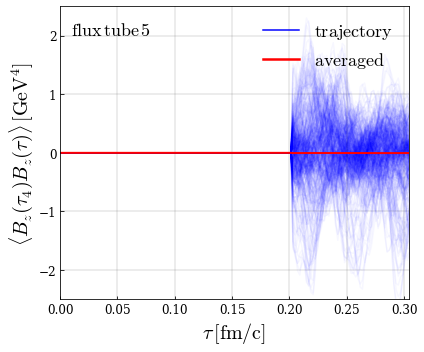

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

plt.plot(delta_tau, magcorr_all[:, 0:N, 2], color='blue', alpha=0.03, linewidth=1.5)
plt.plot(delta_tau, magcorr[:, 2], color='red', linewidth=2)


prev_flux_tube = flux_tube - 1
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=20)
plt.ylabel(fr'$\langle B_z(\tau_{prev_flux_tube})B_z(\tau)\rangle\,\mathrm{{[GeV^4]}}$', fontsize=20)
# plt.title(fr'$\mathrm{{Flux\,tube \,{flux_tube}}}$', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

if flux_tube == 1:
    ylims = [-40, 250]
    xlims = [0, 0.1]
elif flux_tube == 2:
    ylims = [-15, 40]
    xlims = [0, 0.026 + 0.1]
elif flux_tube == 3:
    ylims = [-7, 17]
    xlims = [0, 0.026 + 0.044 + 0.1]
elif flux_tube == 4:
    ylims = [-4.5, 6.5]
    xlims = [0, 0.026 + 0.044 + 0.063 + 0.1]
elif flux_tube == 5:
    ylims = [-2.5, 2.5]
    xlims = [0, 0.026 + 0.044 + 0.063 + 0.071 + 0.1]

plt.xlim(xlims)
plt.ylim(ylims)
# plt.xticks([0, 0.1, 0.2, 0.3, 0.4])
# plt.yticks([-40, 0, 40, 80, 120])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend_handles = [
    Line2D([0], [0], color='blue', linewidth=1.5, label=r'$\mathrm{trajectory}$'),
    Line2D([0], [0], color='red', linewidth=2.5, label=r'$\mathrm{averaged}$') 
]
plt.legend(handles=legend_handles, fontsize=18, frameon=False, loc='upper right')

plt.text(
    0.03, 0.95,
    fr'$\mathrm{{flux\,tube\,{flux_tube}}}$',
    transform=plt.gca().transAxes,
    fontsize=18,
    verticalalignment='top'
)

plt.tight_layout()

# plt.savefig(f'bzcorr_lightlike_tube_{flux_tube}_final.png', dpi=900, facecolor='w')
# plt.savefig('ezcorr_lightlike.pdf', facecolor='w')

plt.show()

Fitted parameters: a = -0.0014308541960127504, b = -12.27399405297073


/n/work00/davrames/condacurraun/lib/python3.6/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in sqrt


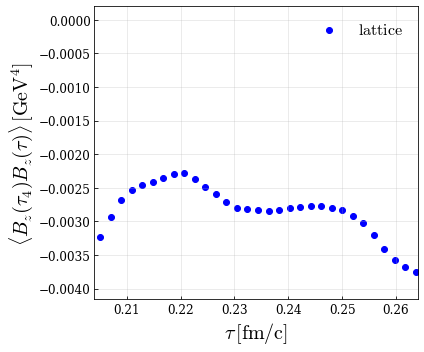

In [10]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))
plt.tick_params(axis='both', direction='in')

def exp_fit_tausq(tau, a, b):
    return a * np.exp(-b * tau**2)

def exp_fit_tau(tau, a, b):
    return a * np.exp(-b * tau)

def exp_fit_tausqrt(tau, a, b):
    return a * np.exp(-b * np.sqrt(tau))

if flux_tube == 1:
    delta_tau_1 = 0.007  
    delta_tau_2 = 0.05
elif flux_tube == 2:
    delta_tau_1 = 0.026 
    delta_tau_2 = delta_tau_1 + 0.04  
elif flux_tube == 3:
    delta_tau_1 = 0.026  + 0.044  
    delta_tau_2 = delta_tau_1 + 0.06
elif flux_tube == 4:
    delta_tau_1 = 0.026  + 0.044 + 0.063  
    delta_tau_2 = delta_tau_1 + 0.02  
elif flux_tube == 5:
    delta_tau_1 = 0.026  + 0.044 + 0.063 + 0.071
    delta_tau_2 = delta_tau_1 + 0.06 

mask = (delta_tau >= delta_tau_1) & (delta_tau <= delta_tau_2)
delta_tau_slice = delta_tau[mask]
magcorr_slice = magcorr[mask, 2]

# popt, pcov = curve_fit(exp_fit_tausqrt, delta_tau_slice, elcorr_slice)
if flux_tube == 1:
    popt, pcov = curve_fit(exp_fit_tau, delta_tau_slice, magcorr_slice)
else:
    popt, pcov = curve_fit(exp_fit_tausq, delta_tau_slice, magcorr_slice)

# Extract the fitted parameters
a, b = popt
print(f"Fitted parameters: a = {a}, b = {b}")

# fit_func = exp_fit_tausqrt(delta_tau_slice, a, b)
if flux_tube == 1:
    fit_func = exp_fit_tau(delta_tau_slice, a, b)
else:
    fit_func = exp_fit_tausq(delta_tau_slice, a, b)

# plt.scatter(delta_tau_slice, elcorr_slice, label="Data", color="blue")
# if flux_tube == 1:
#     plt.scatter(delta_tau, magcorr[:, 2], label=r"$\mathrm{lattice}$", color="blue")
#     label_fit = fr"$\mathrm{{fit}}\,\,ae^{{-b \tau}}$" + "\n" + fr"$a={a:.3f}$" + "\n" + fr"$b={b:.3f}$"
# else:
#     plt.scatter(delta_tau_slice, magcorr_slice, label=r"$\mathrm{lattice}$", color="blue")
#     label_fit = fr"$\mathrm{{fit}}\,\,ae^{{-b \tau^2}}$" + "\n" + fr"$a={a:.3f}$" + "\n" + fr"$b={b:.3f}$"

plt.scatter(delta_tau, magcorr[:, 2], label=r"$\mathrm{lattice}$", color="blue")
label_fit = fr"$\mathrm{{fit}}\,\,ae^{{-b \tau}}$" + "\n" + fr"$a={a:.3f}$" + "\n" + fr"$b={b:.3f}$"

# plt.plot(delta_tau_slice, fit_func, label=label_fit, color="red")
plt.xlabel(r"$\tau\,\mathrm{[fm/c]}$", fontsize=20)
prev_flux_tube = flux_tube - 1
plt.ylabel(fr'$\langle B_z(\tau_{prev_flux_tube})B_z(\tau)\rangle\,\mathrm{{[GeV^4]}}$', fontsize=20)

if flux_tube == 1:
    l = round(1 / b, 3)
    E0 = round(np.sqrt(exp_fit_tau(l, a, b)), 3)
    l += delta_tau_1
else:
    l = round(np.sqrt(1 / b), 3)
    E0 = round(np.sqrt(exp_fit_tausq(l, a, b)), 3)


# plt.text(
#     0.2, 0.73,
#     fr'$\mathrm{{flux\,tube\,{flux_tube}}}$' + "\n" + fr'$B_{flux_tube}={E0}\,\mathrm{{GeV^2}}$' + "\n" + fr'$\,l_{flux_tube}={l}\,\mathrm{{fm}}$',
#     transform=plt.gca().transAxes,
#     fontsize=16,
#     verticalalignment='bottom'
# )

plt.legend(fontsize=16, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

if flux_tube == 1:
    plt.xlim([0, delta_tau_2])
else:
    plt.xlim([delta_tau_1, delta_tau_2])
    # plt.xlim([0, delta_tau_2])
    
plt.grid(alpha=0.3)
plt.tight_layout()
# plt.savefig(f'bzcorr_lightlike_fit_tube_{flux_tube}_final_no_fit.png', dpi=900, facecolor='w')  
# plt.savefig(f'bzcorr_lightlike_fit_tube_{flux_tube}_final.png', dpi=900, facecolor='w')  

plt.show()

In [28]:
tau_e = 1/b
print(f"Exponential time scale: {tau_e:.3f} fm/c")
print(f"Value at exponential time scale: {exp_fit_tau(tau_e, a, b):.3f} GeV^4")

Exponential time scale: 0.005 fm/c
Value at exponential time scale: 0.638 GeV^4


In [20]:
tau_e = 1 / b
print(f"Exponential time scale: {tau_e:.3f} fm/c")
print(f"Value at exponential time scale: {exp_fit_tau(tau_e, a, b):.3f} GeV^4")
tau_hm = np.log(2) / b
print(f"Half maximum time scale: {tau_hm:.3f} fm/c")
print(f"Value at half maximum: {exp_fit_tau(tau_hm, a, b):.3f} GeV^4")
p = 0.9
tau_p = -np.log(1-p) / b
print(f"Percentage time scale (p={p}): {tau_p:.3f} fm/c")
print(f"Value at percentage time scale: {exp_fit_tau(tau_p, a, b):.3f} GeV^4")

Exponential time scale: 0.002 fm/c
Value at exponential time scale: 2.285 GeV^4
Half maximum time scale: 0.001 fm/c
Value at half maximum: 3.105 GeV^4
Percentage time scale (p=0.9): 0.005 fm/c
Value at percentage time scale: 0.621 GeV^4


---
### All flux tubes

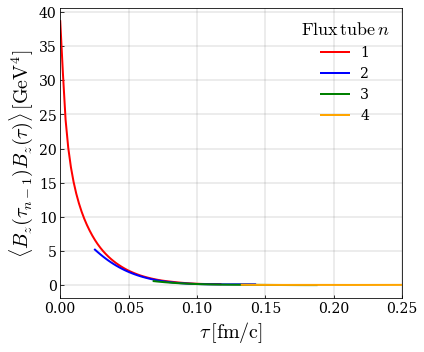

In [11]:
import pickle
import numpy as np

import matplotlib.pyplot as plt

# Initialize lists to store data from all files
all_tau = []
all_magcorr = []

# Loop through the files
for i in range(1, 6):
    with open(f'eik_jet_mag_corr_1_ev_{i}_flux_tube_final.pickle', 'rb') as f:
        data = pickle.load(f)
        tau = data['delta_tau']
        magcorr = data['magcorr'][:, 2]  # Extract the third component of elcorr
        
        # Cut elcorr when the values are 0
        mask = magcorr != 0
        all_tau.append(tau[mask])
        all_magcorr.append(magcorr[mask])

# Plot the data for each flux tube
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))
plt.tick_params(axis='both', direction='in')

plt.xlim([0, 0.25])

colors = ['red', 'blue', 'green', 'orange']
for i in range(4):
    plt.plot(all_tau[i], all_magcorr[i], color=colors[i], linewidth=2, label=f'{i+1}')

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=20)
plt.ylabel(r'$\langle B_z(\tau_{n-1})B_z(\tau)\rangle\,\mathrm{[GeV^4]}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)
plt.legend(fontsize=14, frameon=False, title=r'$\mathrm{Flux\,tube\,}n$', title_fontsize=18, loc='upper right')
plt.tight_layout()

plt.savefig('bzcorr_lightlike_avg_4_flux_tubes_final.png', dpi=900, facecolor='w')
plt.show()

In [16]:
import numpy as np
from scipy.optimize import curve_fit 

def exp_fit_tausq(tau, a, b):
    return a * np.exp(-b * tau**2)

def exp_fit_tau(tau, a, b):
    return a * np.exp(-b * tau)

slice_ranges = [
    (0.007, 0.05),  # For flux tube 1
    (0.026, 0.066),  # For flux tube 2
    (0.07, 0.13),  # For flux tube 3
    (0.133, 0.153),  # For flux tube 4
    # (0.204, 0.304)   # For flux tube 5
]

tau_tubes, bz_tubes = [], []

for i, (delta_tau_1, delta_tau_2) in enumerate(slice_ranges):
    mask = (all_tau[i] >= delta_tau_1) & (all_tau[i] <= delta_tau_2)
    delta_tau_slice = all_tau[i][mask]
    magcorr_slice = all_magcorr[i][mask]

    if i == 0:
        popt, pcov = curve_fit(exp_fit_tau, delta_tau_slice, magcorr_slice)

        a, b = popt
        tau_e = 1 / b
        # value_at_tau_e = np.sqrt(exp_fit_tau(tau_e, a, b))
        value_at_tau_e = exp_fit_tau(tau_e, a, b)
        tau_e += 0.007 # offset for flux tube 1 due to UV cutoff dependence
    else:
        popt, pcov = curve_fit(exp_fit_tausq, delta_tau_slice, magcorr_slice)

        a, b = popt
        tau_e = np.sqrt(1 / b)
        # value_at_tau_e = np.sqrt(exp_fit_tausq(tau_e, a, b))
        value_at_tau_e = exp_fit_tausq(tau_e, a, b)

    tau_tubes.append(round(tau_e,3))
    bz_tubes.append(value_at_tau_e)

    print(f"Flux tube {i+1}:")
    print(f"Fitted parameters: a = {a:.3f}, b = {b:.3f}")
    print(f"Exponential time scale: {tau_e:.3f} fm/c")
    print(f"Value at exponential time scale: {value_at_tau_e:.3f} GeV^4")

Flux tube 1:
Fitted parameters: a = 24.819, b = 51.621
Exponential time scale: 0.026 fm/c
Value at exponential time scale: 9.131 GeV^4
Flux tube 2:
Fitted parameters: a = 6.791, b = 500.985
Exponential time scale: 0.045 fm/c
Value at exponential time scale: 2.498 GeV^4
Flux tube 3:
Fitted parameters: a = 1.789, b = 251.602
Exponential time scale: 0.063 fm/c
Value at exponential time scale: 0.658 GeV^4
Flux tube 4:
Fitted parameters: a = 1.177, b = 200.902
Exponential time scale: 0.071 fm/c
Value at exponential time scale: 0.433 GeV^4


In [17]:
tau_tubes.insert(0, 0)
print("tau_tubes:", tau_tubes)
len_tubes = [sum(tau_tubes[:i+1]) for i in range(len(tau_tubes))]
print("len_tubes:", len_tubes)

tau_tubes: [0, 0.026, 0.045, 0.063, 0.071]
len_tubes: [0, 0.026, 0.071, 0.134, 0.20500000000000002]


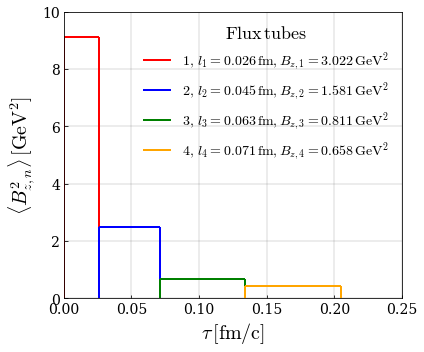

In [19]:
import numpy as np

import matplotlib.pyplot as plt

# Plot the data for each flux tube
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))
plt.tick_params(axis='both', direction='in')

plt.xlim([0, 0.3])

colors = ['red', 'blue', 'green', 'orange']
for i in range(4):
    label_tube = fr"${i+1},\,l_{{{i+1}}}={tau_tubes[i+1]:.3f}\,\mathrm{{fm}}, B_{{z,{i+1}}}={np.sqrt(bz_tubes[i]):.3f}\,\mathrm{{GeV^2}}$"
    plt.hlines(y=bz_tubes[i], xmin=len_tubes[i], xmax=len_tubes[i+1], color=colors[i], linewidth=2, label=label_tube)
    plt.vlines(x=len_tubes[i], ymin=0, ymax=bz_tubes[i], color=colors[i], linewidth=2)  # Vertical line at xmin
    plt.vlines(x=len_tubes[i+1], ymin=0, ymax=bz_tubes[i], color=colors[i], linewidth=2)  # Vertical line at xmax

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=20)
plt.ylabel(r'$\langle B_{z,n}^2\rangle\,\mathrm{[GeV^2]}$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 0.25])
plt.ylim([0, 10])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)
plt.legend(fontsize=14, frameon=False, title=r'$\mathrm{Flux\,tubes}$', title_fontsize=18, loc='upper right')


plt.tight_layout()

plt.savefig('bzcorr_lightlike_avg_4_flux_tubes_effective_final.png', dpi=900, facecolor='w')
plt.show()

---
### UV cutoff dependence

In [ ]:
import copy
# uvcutoff = "lattice"
# Ns = [256, 512, 1024]
# nevents = [16 * 3, 4 * 3, 1 * 3] 
# DTS_values = [32, 16, 8]  # Time step values for each N
Ns = [256]
nevents = [16 * 8] 
DTS_values = [64]  # Time step values for each N

for Nval in Ns:
    latticeUV_N = Nval / L * hbarc * 2 * np.sqrt(2)
    print(f"Lattice UV cutoff: {latticeUV_N:.2f} GeV")
    pN = copy.deepcopy(p)  # Make a deep copy to isolate
    pN["N"] = Nval
    pN["n_events"] = nevents[Ns.index(Nval)]
    pN["DTS"] = DTS_values[Ns.index(Nval)]

    elcorrs, magcorrs = [], []
    with tqdm(total=pN["n_events"]) as pbar:
        for ev in range(pN["n_events"]):
            # print("Simulating event", ev + 1)
            delta_tau, elcorr, magcorr, elcorr_all, magcorr_all = simulate(ev, pN)
            elcorrs.append(elcorr)
            magcorrs.append(magcorr)

            pbar.set_description("N = " + str(Nval))    
            pbar.update(1)

    elcorr = np.mean(elcorrs, axis=0)
    magcorr = np.mean(magcorrs, axis=0)

    output = {"delta_tau": delta_tau, "elcorr": elcorr, "magcorr": magcorr,"p": pN}  
    with open(f"eik_jet_el_mag_corr_avg_lattice_UV_N_{Nval}.pickle", 'wb') as f:
        pickle.dump(output, f)
    

In [85]:
flux_tube = 1

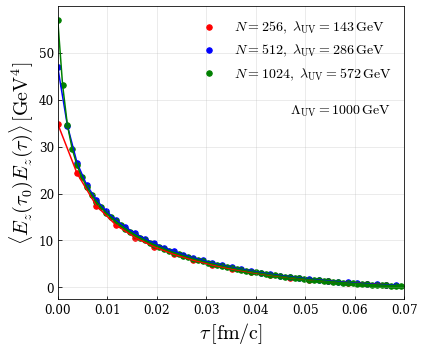

In [86]:
import pickle
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

Ns = [256, 512, 1024]
latticeUV_N = [round(Nval / L * hbarc * 2 * np.sqrt(2)) for Nval in Ns]
# labels = [r'$N=256$', r'$N=512$', r'$N=1024$']
labels = [
    fr'$N={N},\ \lambda_{{\mathrm{{UV}}}}={uv}\,\mathrm{{GeV}}$'
    for N, uv in zip(Ns, latticeUV_N)
]

colors = ['red', 'blue', 'green']

plt.figure(figsize=(6, 5))
plt.tick_params(axis='both', direction='in')

for N_val, color, label in zip(Ns, colors, labels):
    fname = f"eik_jet_el_mag_corr_avg_lattice_UV_N_{N_val}.pickle"
    # fname = f"eik_jet_el_mag_corr_1_ev_{flux_tube}_flux_tube_N_{N_val}_UV_10.pickle"
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    delta_tau = data['delta_tau']
    elcorr = data['elcorr']

    # Define the slice range
    if flux_tube == 1:
        delta_tau_1 = 0.00
        delta_tau_2 = 0.07
    else:
        delta_tau_1 = 0.00
        delta_tau_2 = 0.06

    mask = (delta_tau >= delta_tau_1) & (delta_tau <= delta_tau_2)
    delta_tau_slice = delta_tau[mask]
    elcorr_slice = elcorr[mask, 2]

    plt.plot(delta_tau_slice, elcorr_slice, color=color, linestyle='-', linewidth=1.5)
    plt.scatter(delta_tau_slice, elcorr_slice, color=color, label=label, s=30)

plt.xlabel(r"$\tau\,\mathrm{[fm/c]}$", fontsize=20)
plt.ylabel(r"$\langle E_z(\tau_0)E_z(\tau)\rangle\,\mathrm{[GeV^4]}$", fontsize=20)
plt.legend(fontsize=14, frameon=False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim([delta_tau_1, delta_tau_2])
# plt.xlim([delta_tau_1, 0.04])

plt.text(
    0.67, 0.62,
    r'$\Lambda_{\mathrm{UV}}=1000\,\mathrm{GeV}$',
    transform=plt.gca().transAxes,
    fontsize=14,
    verticalalignment='bottom'
)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'ezcorr_lightlike_flux_tube_1_lattice_UV_dep.png', dpi=900, facecolor='w') 
plt.show()

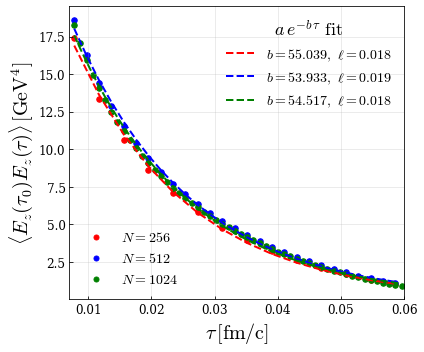

In [87]:
import pickle
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

Ns = [256, 512, 1024]
latticeUV_N = [round(Nval / L * hbarc * 2 * np.sqrt(2)) for Nval in Ns]
labels = [r'$N=256$', r'$N=512$', r'$N=1024$']
# labels = [fr'$N={N}\,\mathrm{{lattice}}$' for N in Ns]

colors = ['red', 'blue', 'green']

def exp_fit_tausq(tau, a, b):
    return a * np.exp(-b * tau**2)

def exp_fit_tau(tau, a, b):
    return a * np.exp(-b * tau)

def exp_fit_tausqrt(tau, a, b):
    return a * np.exp(-b * np.sqrt(tau))

plt.figure(figsize=(6, 5))
plt.tick_params(axis='both', direction='in')

for N_val, color, label in zip(Ns, colors, labels):
    fname = f"eik_jet_el_mag_corr_avg_lattice_UV_N_{N_val}.pickle"
    # fname = f"eik_jet_el_mag_corr_1_ev_{flux_tube}_flux_tube_N_{N_val}_UV_10.pickle"
    with open(fname, 'rb') as f:
        data = pickle.load(f)
    delta_tau = data['delta_tau']
    elcorr = data['elcorr']

    # Define the slice range
    if flux_tube == 1:
        delta_tau_1 = 0.007
        delta_tau_2 = 0.06

    mask = (delta_tau >= delta_tau_1) & (delta_tau <= delta_tau_2)
    delta_tau_slice = delta_tau[mask]
    elcorr_slice = elcorr[mask, 2]

    # Perform the curve fitting
    # if N_val == 256 or N_val == 512 or N_val == 1024:
    # if N_val == 256:
    # # if N_val == 2:
    #     popt, pcov = curve_fit(exp_fit_tausq, delta_tau_slice, elcorr_slice)
    #     fit_func = exp_fit_tausq(delta_tau_slice, *popt)
    #     fit_label = f"{label} fit $a e^{{-b \\tau^2}}$\n$a={popt[0]:.3f}, b={popt[1]:.3f}$"  
    # else:
    popt, pcov = curve_fit(exp_fit_tau, delta_tau_slice, elcorr_slice)
    fit_func = exp_fit_tau(delta_tau_slice, *popt)
    # fit_label = f"{label} fit $a e^{{-b \\tau}}$\n$a={popt[0]:.3f}, b={popt[1]:.3f}$"
    fit_label = fr'$b={popt[1]:.3f},\ \ell={1/popt[1]:.3f}$'
        
    # plt.plot(delta_tau_slice, elcorr_slice, color=color, linestyle='-', linewidth=1.5)
    plt.scatter(delta_tau_slice, elcorr_slice, color=color, s=30)
    plt.plot(delta_tau_slice, fit_func, color=color, linestyle='--', label=fit_label, linewidth=2.0)

plt.xlabel(r"$\tau\,\mathrm{[fm/c]}$", fontsize=20)
plt.ylabel(r"$\langle E_z(\tau_0)E_z(\tau)\rangle\,\mathrm{[GeV^4]}$", fontsize=20)
plt.legend(fontsize=14, frameon=False, title=r'$a\,e^{-b\,\tau}\,\,\mathrm{fit}$', title_fontsize=18)


ax = plt.gca()
fit_legend = ax.legend(fontsize=14, frameon=False, title=r'$a\,e^{-b\,\tau}\,\,\mathrm{fit}$', title_fontsize=18)
ax.add_artist(fit_legend)  

handles = [plt.Line2D([], [], color=color, marker='o', linestyle='None', markersize=5, label=label)
    for color, label in zip(colors, labels)]

ax.legend(handles=handles, loc='lower left', fontsize=14, frameon=False, title_fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim([delta_tau_1, delta_tau_2])

plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f'ezcorr_lightlike_flux_tube_1_fit_N.png', dpi=900, facecolor='w')  
plt.show()

---

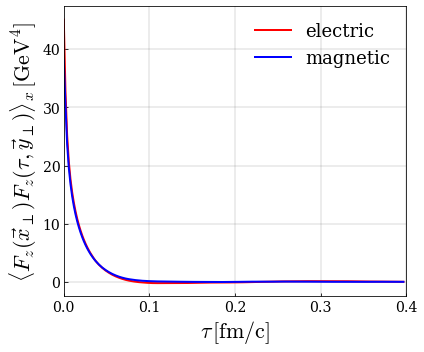

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Computer Modern']
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

plt.plot(delta_tau, elcorr[:, 2], color='red', linewidth=2, label='electric')
plt.plot(delta_tau, magcorr[:, 2], color='blue', linewidth=2, label='magnetic')


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle F_z(\vec{x}_\perp)F_z(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
# plt.title(r'$elcorr$ as a function of $\Delta \tau$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 0.4])
# plt.xlim([0, 0.2])
# plt.ylim([-50, 130])
plt.xticks([0, 0.1, 0.2, 0.3, 0.4])
# plt.yticks([0, 4, 8, 12])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# legend_handles = [
#     # Line2D([0], [0], color='blue', alpha=0.2, linewidth=3, label='trajectory'),
#     Line2D([0], [0], color='red', linewidth=3, label='averaged') 
# ]
plt.legend(fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig(f'ezcorr_lightlike_avg_tube_{flux_tube}_latest.png', dpi=900, facecolor='w')
# plt.savefig('ezcorr_lightlike_avg.pdf', facecolor='w')

plt.show()

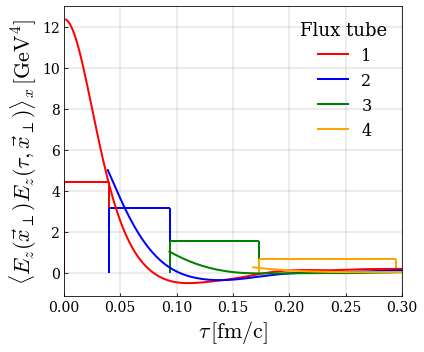

In [19]:
import numpy as np

import matplotlib.pyplot as plt

# Plot the data for each flux tube
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))
plt.tick_params(axis='both', direction='in')

plt.xlim([0, 0.3])

colors = ['red', 'blue', 'green', 'orange']
for i in range(4):
    plt.hlines(y=ez_tubes[i], xmin=len_tubes[i], xmax=len_tubes[i+1], color=colors[i], linewidth=2, label=f'{i+1}')
    plt.vlines(x=len_tubes[i], ymin=0, ymax=ez_tubes[i], color=colors[i], linewidth=2)  # Vertical line at xmin
    plt.vlines(x=len_tubes[i+1], ymin=0, ymax=ez_tubes[i], color=colors[i], linewidth=2)  # Vertical line at xmax
    plt.plot(all_tau[i], all_elcorr[i], color=colors[i], linewidth=2)

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_z(\vec{x}_\perp)E_z(\tau, \vec{x}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.xlim([0, 0.3])
plt.yticks(fontsize=14)
plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)
plt.legend(fontsize=16, frameon=False, title='Flux tube', title_fontsize=18, loc='upper right')
plt.tight_layout()

# plt.savefig('ezcorr_lightlike_avg_4_flux_tubes_effective_correct.png', dpi=900, facecolor='w')
plt.show()

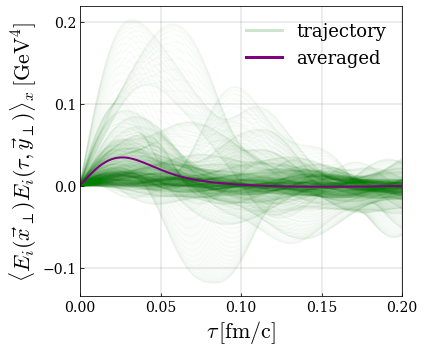

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

# plt.plot(delta_tau, magcorr_all[:, 0:N, 2], color='green', alpha=0.02, linewidth=1.5)
# plt.plot(delta_tau, magcorr[:, 2], color='purple', linewidth=2)

plt.plot(delta_tau, 2 * elcorr_all[:, 0:N, 0], color='green', alpha=0.02, linewidth=1.5)
plt.plot(delta_tau, 2 * elcorr[:, 0], color='purple', linewidth=2)


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_i(\vec{x}_\perp)E_i(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 0.2])
# plt.ylim([-50, 130])
plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
plt.yticks([-0.1, 0, 0.1, 0.2])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

legend_handles = [
    Line2D([0], [0], color='green', alpha=0.2, linewidth=3, label='trajectory'),
    Line2D([0], [0], color='purple', linewidth=3, label='averaged') 
]
plt.legend(handles=legend_handles, fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig('bzcorr_lightlike.png', dpi=900, facecolor='w')
# plt.savefig('eicorr_lightlike.pdf', facecolor='w')

plt.show()

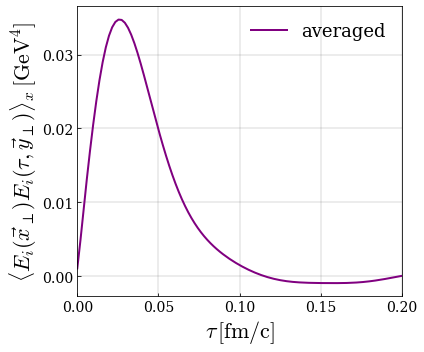

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

plt.plot(delta_tau, 2 * elcorr[:, 0], color='purple', linewidth=2, label='averaged')


plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle E_i(\vec{x}_\perp)E_i(\tau, \vec{y}_\perp)\rangle_x\,\mathrm{[GeV^4]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 0.2])
# plt.ylim([-50, 130])
plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
plt.yticks([0, 0.01, 0.02, 0.03])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

plt.legend(fontsize=18, frameon=False)

plt.tight_layout()

# plt.savefig('bzcorr_lightlike_avg.png', dpi=900, facecolor='w')
# plt.savefig('eicorr_lightlike_avg.pdf', facecolor='w')

plt.show()

---
Classical $\hat{q}$ with or without transverse components

In [ ]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

import sys
sys.path.append('/n/work00/davrames/curraun/')

import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle
from tqdm import tqdm

from curraun.qhat import TransportedForce
from curraun.qhat_correlators import LongTransportedForce

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


In [ ]:
# Define hbar * c in units of GeV * fm
hbarc = 0.197326 

# Simulation box parameters
L = 2      # Length of simulation box [fm]
N = 1024     # Number of lattice sites
DTS = 8     # Time step

# N = 128     # Number of lattice sites
# DTS = 4     # Time step
n_events = 10        # Number of events

# MV model parameters
Qs = 2.0        # Saturation scale [GeV]       
NS = 50     # Number of color sheets
factor = 0.8        # Qs/g2mu ratio from Lappi, for Ns=50 sheets
g2mu = Qs / factor      # MV model parameter times squared coupling [GeV]     
G = np.pi * np.sqrt(1 / np.log(Qs / 0.2))       # Running coupling constant	          		
MU = g2mu / G**2        # MV model parameter         	
M = 0.1 * G**2 * MU     # Intrared regulator [GeV]        
UV = 10.0       # Ultraviolet regulator [GeV] 

# taus = [0.01, 0.05, 0.1, 0.15, 0.3, 0.5]     # Formation times [GeV/fm]
# taus = [0.01, 0.02, 0.05, 0.1, 0.3, 0.5]
tau_max = 1.0    # Simulation time [GeV/fm]

In [ ]:
def simulate_qhat(ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_max / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, G)
    mv.set_seed(124)
    va = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
    vb = mv.wilson(s, mu= MU / E0, m= M / E0, uv= UV / E0, num_sheets= NS)
    initial.init(s, va, vb)

    # Initialize the Qhat module
    qhat = TransportedForce(s)
    qhat_long = LongTransportedForce(s)
    mom_broad, mom_broad_long, tau =  [], [], []

    if use_cuda:
        qhat.copy_to_device()
        qhat_long.copy_to_device()

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Compute momentum broadening from Qhat module
            if t % DTS == 0:
                if use_cuda:
                    qhat.copy_mean_to_host()
                    qhat_long.copy_mean_to_host()

                # Units GeV^2
                mom_broad.append(qhat.p_perp_mean * E0 ** 2)
                mom_broad_long.append(qhat_long.p_perp_mean * E0 ** 2)

                tau.append(t / DTS * a)
                
                if use_cuda:
                    qhat.copy_mean_to_device()
                    qhat_long.copy_mean_to_device()
            qhat.compute()
            qhat_long.compute()

            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad, mom_broad_long, tau

In [ ]:
nevents = 5

mom_broads, mom_broads_long = [], []
for ev in range(nevents):
    mom_broad_ev, mom_broad_long_ev, tau = simulate_qhat(ev)
    mom_broads.append(mom_broad_ev)
    mom_broads_long.append(mom_broad_long_ev)

mom_broad = np.mean(mom_broads, axis=0)
mom_broad_long = np.mean(mom_broads_long, axis=0)

Event 5: 100%|██████████| 4096/4096 [09:30<00:00,  7.18it/s]


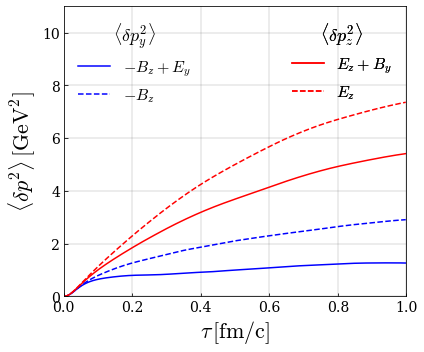

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

labels = [r'$E_y-B_z$', r'$E_z+B_y$']
labels_long = [r'$-B_z$', r'$E_z$']
colors = ['blue', 'red']

for i in [1,2]:
    plt.plot(tau, mom_broad[:, i], color=colors[i-1])
    plt.plot(tau, mom_broad_long[:, i], color=colors[i-1], linestyle='--')

# plt.plot(xplus, mom_broad[:, 1] + mom_broad[:, 2], label="y+z")

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\langle \delta p^2\rangle\,\mathrm{[GeV^2]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 1.0])
plt.ylim([0, 11])
# plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
# plt.yticks([0, 0.01, 0.02, 0.03])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# plt.legend(fontsize=18, frameon=False)

legend1 = plt.legend(handles=[plt.Line2D([0], [0], color='blue', linestyle='-', label=r'$-B_z+E_y$'),
                              plt.Line2D([0], [0], color='blue', linestyle='--', label=r'$-B_z$')],
                     title=r'$\langle \delta p^2_y\rangle$', title_fontsize=18, fontsize=16, frameon=False, loc='upper left')

plt.gca().add_artist(legend1)

legend2 = plt.legend(handles=[plt.Line2D([0], [0], color='red', linestyle='-', label=r'$E_z+B_y$'),
                              plt.Line2D([0], [0], color='red', linestyle='--', label=r'$E_z$')],
                     title=r'$\langle \delta p^2_z\rangle$', title_fontsize=18, fontsize=16, frameon=False, loc='upper right')

plt.gca().add_artist(legend2)

plt.tight_layout()

# plt.savefig('mom_broad_eb_contrib.pdf', facecolor='w')
plt.savefig('mom_broad_eb_contrib.png', dpi=900, facecolor='w')

plt.show()

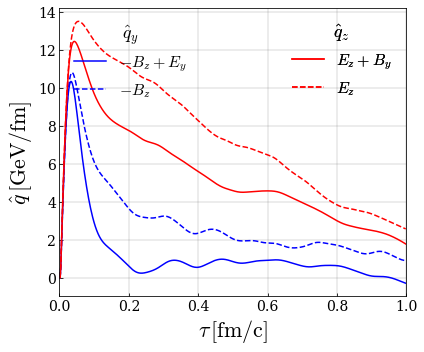

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']
plt.rcParams['mathtext.fontset'] = 'cm'

plt.figure(figsize=(6, 5))

plt.tick_params(axis='both', direction='in')

labels = [r'$E_y-B_z$', r'$E_z+B_y$']
labels_long = [r'$-B_z$', r'$E_z$']
colors = ['blue', 'red']

for i in [1,2]:
    qhat = np.diff(mom_broad[:, i]) / np.diff(tau)
    plt.plot(tau[1:len(tau)], qhat, color=colors[i-1])
    
    qhat_long = np.diff(mom_broad_long[:, i]) / np.diff(tau)
    plt.plot(tau[1:len(tau)], qhat_long, color=colors[i-1], linestyle='--')

# plt.plot(xplus, mom_broad[:, 1] + mom_broad[:, 2], label="y+z")

plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$', fontsize=22)
plt.ylabel(r'$\hat{q}\,\mathrm{[GeV/fm]}$', fontsize=22)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0, 1.0])
# plt.ylim([0, 11])
# plt.xticks([0, 0.05, 0.1, 0.15, 0.2])
# plt.yticks([0, 0.01, 0.02, 0.03])

plt.grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.2)

# plt.legend(fontsize=18, frameon=False)

legend1 = plt.legend(handles=[plt.Line2D([0], [0], color='blue', linestyle='-', label=r'$-B_z+E_y$'),
                              plt.Line2D([0], [0], color='blue', linestyle='--', label=r'$-B_z$')],
                     title=r'$\hat{q}_y$', title_fontsize=18, fontsize=16, frameon=False, loc='upper left')

plt.gca().add_artist(legend1)

legend2 = plt.legend(handles=[plt.Line2D([0], [0], color='red', linestyle='-', label=r'$E_z+B_y$'),
                              plt.Line2D([0], [0], color='red', linestyle='--', label=r'$E_z$')],
                     title=r'$\hat{q}_z$', title_fontsize=18, fontsize=16, frameon=False, loc='upper right')

plt.gca().add_artist(legend2)

plt.tight_layout()

# plt.savefig('qhat_eb_contrib.pdf', facecolor='w')
plt.savefig('qhat_eb_contrib.png', dpi=900, facecolor='w')

plt.show()